# Notebook used  to experiment with different models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from sklearn.metrics import  mean_pinball_loss

In [5]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00:00:010:01
  Using cached Cython-0.29.33-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
df = pd.read_csv("../traces/traces_persona.csv",parse_dates=[0])
diff = [df["reconsile_dates"][i] - df["reconsile_dates"][i-1] for i in range(1,len(df["reconsile_dates"]))]
diff_df = pd.DataFrame({"diff": diff, "sec": [x.total_seconds() for x in diff]}) 

In [43]:
df,diff_df

(                      reconsile_dates
 0    2023-01-17 13:45:57.861000+00:00
 1    2023-01-17 13:46:00.918000+00:00
 2    2023-01-17 13:46:05.918000+00:00
 3    2023-01-17 13:46:11.046000+00:00
 4    2023-01-17 13:46:16.173000+00:00
 ...                               ...
 996  2023-01-17 15:12:21.972000+00:00
 997  2023-01-17 15:12:27.178000+00:00
 998  2023-01-17 15:12:32.338000+00:00
 999  2023-01-17 15:12:37.529000+00:00
 1000 2023-01-17 15:12:42.682000+00:00
 
 [1001 rows x 1 columns],
                       diff    sec
 0   0 days 00:00:03.057000  3.057
 1          0 days 00:00:05  5.000
 2   0 days 00:00:05.128000  5.128
 3   0 days 00:00:05.127000  5.127
 4   0 days 00:00:05.144000  5.144
 ..                     ...    ...
 995 0 days 00:00:05.180000  5.180
 996 0 days 00:00:05.206000  5.206
 997 0 days 00:00:05.160000  5.160
 998 0 days 00:00:05.191000  5.191
 999 0 days 00:00:05.153000  5.153
 
 [1000 rows x 2 columns])

In [45]:
df.describe(),diff_df.describe()

/tmp/ipykernel_13409/1579199578.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(),diff_df.describe()


(                         reconsile_dates
 count                               1001
 unique                              1001
 top     2023-01-17 13:45:57.861000+00:00
 freq                                   1
 first   2023-01-17 13:45:57.861000+00:00
 last    2023-01-17 15:12:42.682000+00:00,
                             diff          sec
 count                       1000  1000.000000
 mean      0 days 00:00:05.204821     5.204821
 std    0 days 00:00:00.611235877     0.611236
 min       0 days 00:00:00.206000     0.206000
 25%       0 days 00:00:05.168750     5.168750
 50%       0 days 00:00:05.198000     5.198000
 75%       0 days 00:00:05.230000     5.230000
 max       0 days 00:00:21.442000    21.442000)

In [18]:
df_stationarityTest = adfuller(df['reconsile_dates'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.0


In [43]:
a = df['reconsile_dates'][1]- df['reconsile_dates'][0]
a.microseconds

57000

/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


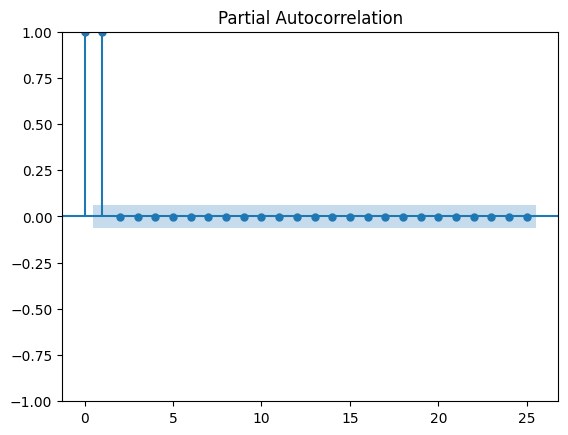

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['reconsile_dates'], lags=25)

# only use 2 long wide interval?

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d73262590>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d73261030>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d732622f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d73262ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d73263190>],
 'means': []}

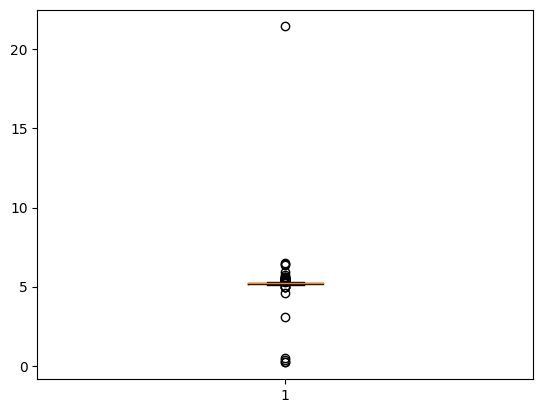

In [55]:
plt.boxplot([diff_df["sec"]])

(array([  2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   4., 480., 443.,  47.,   9.,   5.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

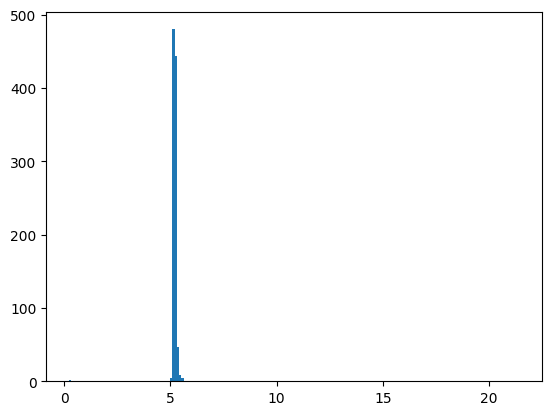

In [9]:
plt.hist(diff_df["sec"],bins=200)

# choosing loss function

In [3]:
# as defined in the scikit-learn  docs
# sklearn.metrics.mean_pinball_loss
def pinball_loss(y_true,y_pred, alpha):
    diff = y_true - y_pred
    sign = int(diff >= 0)
    
    loss = alpha * sign  * diff - (1 - alpha) * (1 - sign) * diff
    return loss

def total_perside_piball_loss(y_true_array,y_pred_array, alpha=0.25):
    assert len(y_pred_array) == len(y_true_array)
    underEstimate = []
    overEstimate = []
    totalEstimate = []
    for y_true,y_pred in zip(y_true_array,y_pred_array):

        diff = y_true - y_pred
        sign = int(diff >= 0)
        
        score = pinball_loss(y_true=y_true, y_pred=y_pred,alpha=alpha)
        
        if sign == 0:
            overEstimate.append(score)
        else:
            underEstimate.append(score)
        totalEstimate.append(score)
    
    underEstimate_score = np.mean(underEstimate)
    overEstimate_score = np.mean(overEstimate)
    ##print(totalEstimate)
    total_score = np.mean(totalEstimate)
    
    print(f"there are {len(underEstimate)} underEstimates with mean {underEstimate_score} ")
    print(f"there are {len(overEstimate)} overEstimates with mean {overEstimate_score}")
    print(f"total mean absolute pinball score {total_score}")
    return (underEstimate_score,overEstimate_score,total_score)






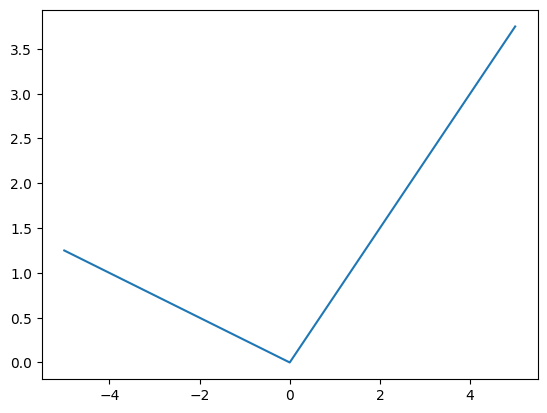

In [4]:
alpha = 0.25 
x = np.concatenate([np.arange(-5,0,0.1), np.arange(0,5.1,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
plt.plot(x,y)


In [17]:
pinball_loss(0,5.2117485916887-5.136,0.25)

0.056811443766524805

In [28]:
pinball_loss(0,1,0.25)

0


0.75

## auto regression

In [12]:
train_data = diff_df["sec"][:len(df)-200]
test_data = diff_df["sec"][len(df)-200:]

In [5]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

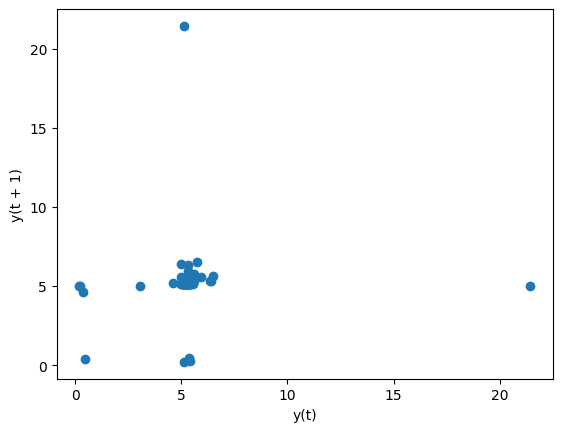

In [46]:
lag_plot(diff_df["sec"])

not really a lot of corrolation, no real line  visable

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

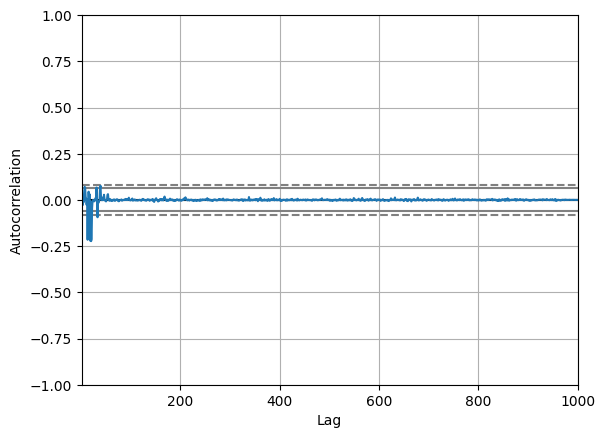

In [47]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_df["sec"])

as expected, since the times are constant, no real big  swings, by adding more lag, we don't gain anything 

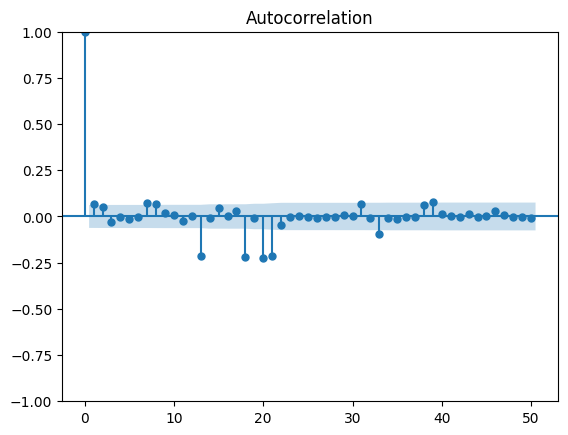

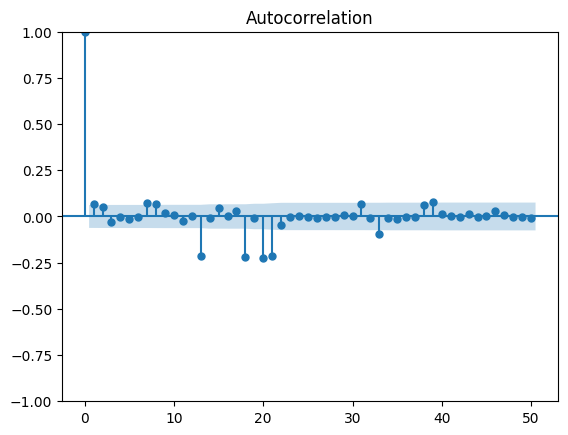

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff_df["sec"], lags=50)

after 25 we see only small differences

In [65]:
model = AutoReg(train_data, lags=10).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    sec   No. Observations:                  801
Model:                    AutoReg(10)   Log Likelihood                -813.099
Method:               Conditional MLE   S.D. of innovations              0.676
Date:                Sun, 26 Feb 2023   AIC                           1650.198
Time:                        12:30:32   BIC                           1706.277
Sample:                            10   HQIC                          1671.752
                                  801                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2236      0.527      8.018      0.000       3.191       5.256
sec.L1         0.0605      0.036      1.702      0.089      -0.009       0.130
sec.L2         0.0527      0.036      1.479      0.1

In [66]:
pred = model.predict(start=801, end=(999), dynamic=False)

/tmp/ipykernel_8702/1787682364.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


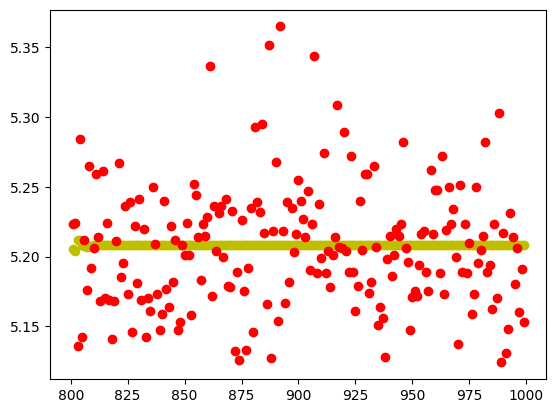

In [67]:

plt.plot(pred,'yo')
plt.plot(test_data,'yo', color='red')

In [68]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 93 underEstimates with mean 0.008869325367786214 
there are 106 overEstimates with mean 0.02486451147884523
total mean absolute pinball score 0.01738937425106388


(0.008869325367786214, 0.02486451147884523, 0.01738937425106388)

In [69]:
mean_pinball_loss(test_data,pred,alpha=0.25)

0.01738937425106388

In [40]:
(93*0.00886090487541144 + 106 * 0.024891221882406035)/199

0.01739966669823268

In [33]:
difference = test_data - pred


In [34]:
np.sum(np.abs(difference))

0.03424229132177442

In [37]:
max(difference)

0.15689612579134504

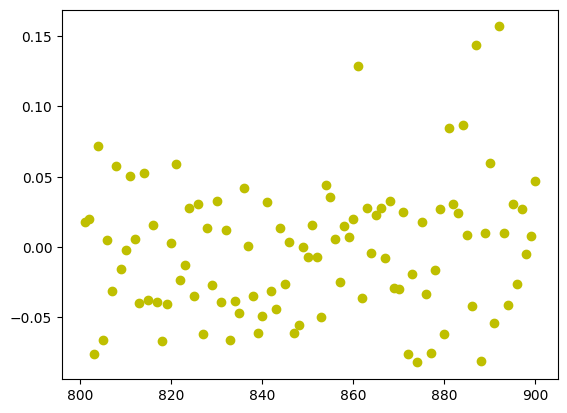

In [82]:
plt.plot(difference[0:100],"yo")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f86c9317700>,
 'caps': [<matplotlib.lines.Line2D at 0x7f86c9316ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f86c9146920>],
 'medians': [<matplotlib.lines.Line2D at 0x7f86c93179a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f86c93156c0>],
 'means': []}

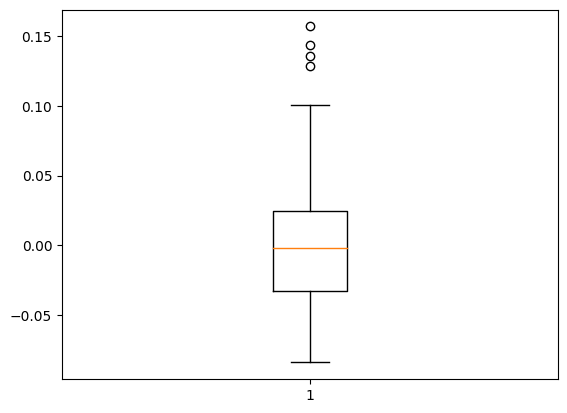

In [83]:
plt.boxplot(difference)

# instead of predicting all test results at a time, do 1 by 1 and relearn like  our framework can do

In [13]:

pred = []
for i in range(801,1000):
    model = AutoReg(diff_df["sec"][:i], lags=10).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])

    

In [14]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 92 underEstimates with mean 0.009244003971309079 
there are 107 overEstimates with mean 0.02511280888429526
total mean absolute pinball score 0.01777647696472376


(0.009244003971309079, 0.02511280888429526, 0.01777647696472376)

as expected  we do not  see a lot of improvement

# arima

In [6]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [20]:
train_data = diff_df["sec"][:len(df)-200]
test_data = diff_df["sec"][len(df)-200:]

In [15]:
adf,pval,_,_,_,_ = adfuller(diff_df["sec"])
print(f"p value {pval} < 0.05 => stationairy")

p value 1.7417236011374657e-24 < 0.05 => stationairy


In [17]:
model = pm.auto_arima(diff_df["sec"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6152.731, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2472.050, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5069.922, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1853.852, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1856.332, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1853.352, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1854.101, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1855.204, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1854.695, Time=0.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1856.101, Time=0.86 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.231 seconds


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -922.676
Date:                Mon, 27 Feb 2023   AIC                           1853.352
Time:                        17:26:33   BIC                           1872.983
Sample:                             0   HQIC                          1860.813
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6063      0.265     17.362      0.000       4.086       5.126
ar.L1          0.0643      0.013      4.988      0.000       0.039       0.090
ar.L2          0.0506      0.048      1.048      0.295      -0.044       0.145
sigma2         0.3706      0.002    232.902      0.000       0.368       0.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          11316047.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            16.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
model = SARIMAX(train_data, order=(2, 0, 0))

In [28]:
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20860D+00    |proj g|=  4.57718D-03

At iterate    5    f=  1.20859D+00    |proj g|=  7.01555D-04

At iterate   10    f=  1.20858D+00    |proj g|=  6.32112D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.321D-06   1.209D+00
  F =   1.2085804439383512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  801
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -968.073
Date:                Mon, 27 Feb 2023   AIC                           1942.146
Time:                        17:35:07   BIC                           1956.203
Sample:                             0   HQIC                          1947.546
                                - 801                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5034      0.004    128.593      0.000       0.496       0.511
ar.L2          0.4882      0.005    105.620      0.000       0.479       0.497
sigma2         0.6533      0.003    211.044      0.000       0.647       0.659
===================================================================================
Ljung-Box (L1) (Q):                  13.51   Jarque-Bera (JB):           1811319.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             7.68
Prob(H) (two-sided):                  0.00   Kurtosis:                       235.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
pred = result.predict(start=801, end=(999))

/tmp/ipykernel_6088/999615282.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


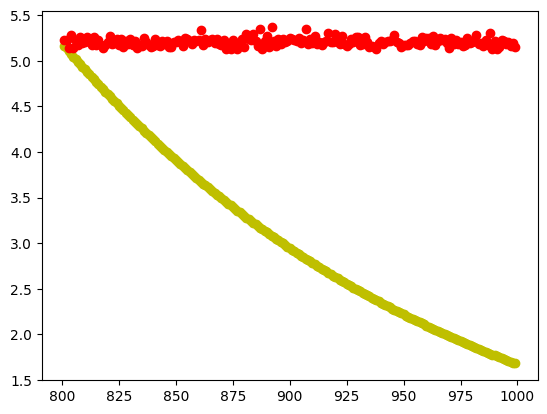

In [30]:
plt.plot(pred,'yo')
plt.plot(test_data,'yo', color='red')

In [31]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 199 underEstimates with mean 0.5253907602859492 
there are 0 overEstimates with mean nan
total mean absolute pinball score 0.5253907602859492


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.5253907602859492, nan, 0.5253907602859492)

predicting that far into the future is pritty bad

In [ ]:
pred = []
for i in range(801,1000):
    model = SARIMAX(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


In [33]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 170 underEstimates with mean 0.018288573610972775 
there are 29 overEstimates with mean 0.01960165803133733
total mean absolute pinball score 0.018479927621980675


(0.018288573610972775, 0.01960165803133733, 0.018479927621980675)

model predicts pritty good, underestimates more, which is better for our framework

/tmp/ipykernel_6088/1564517916.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


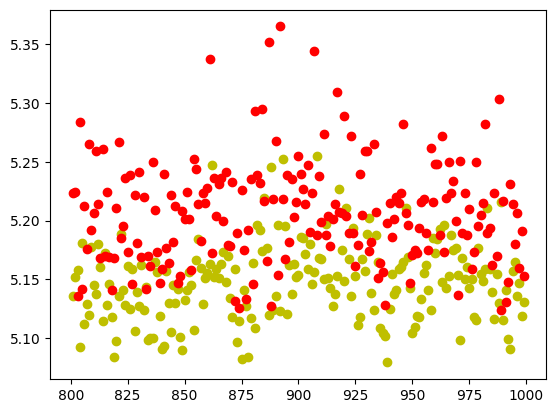

In [36]:

plt.plot(range(801,1000),pred,'yo')
plt.plot(test_data,'yo', color='red')